# Global Temperature Trends : Unveiling CO2 and Solar Links to Temperature

**Authors**  
**Yash Pimpale - 22202250**  
**Aboli Pathak - 22202284**  

# Global Temperature Increase

### Land Surface Temperature Data Extraction

Get coordinates of 100 cities evenly distributed globally

In [2]:
#Load required libraries
import pandas as pd
import numpy as np
import netCDF4 as nc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib as mplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import PIL

#Read city location data. Select only first 430 records to get 100 unique countries.
city_location = pd.read_csv("worldcities_locations.csv", nrows = 430)

#Extract first city for each country present in the csv, so that we have 1 city for each country.
first_cities = city_location.groupby('country').first().reset_index()

#Concatenate extracted cities to form final dataframe
final_cities = pd.concat([first_cities], ignore_index=True)
final_cities.head()

,country,city,lat,lng,population
0,Afghanistan,Kabul,34.5167,69.1833,3277000
1,Algeria,Algiers,36.7631,3.0506,3354000
2,Angola,Luanda,-8.8383,13.2344,5172900
3,Argentina,Buenos Aires,-34.6025,-58.3975,12795000
4,Australia,Sydney,-33.9200,151.1852,4630000


Monthly Temperature data for each latitude and longitude from year 1880-2023 is present in a grided form in .netcdf file. We need to extract data for specific cities from this .netcdf file for all the years. Below steps are followed:-  

1. Extract Temperature, latitude and longitude present in .netcdf file.  
2. Actual latitude and longitude for each city are different than those present in .netcdf file. Hence we need to compute square distance between each latitude and longitude of respective city and find the nearest co-ordinate.  
3. Extract data for that city and add it in final dataframe. 
4. Repeat step 3 till data for each city is extracted and present in final dataframe.
5. Final dataframe will contain Date, city, temperature, actual latitude, actual longitude, Nearest latitude, Nearest longitude and country column.  

Note: Grided Form means latitude and longitude are divided into a sequence from max to min values. For e.g. latitude range from -90 to +90. Then it will be present as -90, -88, -86,....., +86, +88, +90.

In [3]:
#Extract data for all 100 cities from netcdf file in a dataframe

#Set file name
file_path = 'gistemp1200_GHCNv4_ERSSTv5.nc' 

#Open netCDF file
dataset = nc.Dataset(file_path)

#Read the latitude, longitude, time and surface temperature data
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
temp = dataset.variables['tempanomaly'][:]
time = dataset.variables['time'][:]
#Extract unit of time
units = dataset.variables['time'].units

#Convert blank values to -99 which will be removed at the end
temp[np.ma.getmaskarray(temp)] = -99

#Set start and end date for which the data is present in netcdf file i.e. from 1880-01-15 to 2023-05-15.
starting_date = dataset.variables['time'].units[11:21]
ending_date = '2023-05-15'

#Create range of date as per values present in netcdf file (monthly data for each year and locations)
date_range = pd.date_range(starting_date, ending_date, freq = 'MS')
#Create empty dataframe with date as index
df = pd.DataFrame(0, columns = ['City', 'Temperature', 'Actual_Lat', 'Actual_Lon', 'Nearest_Lat', 'Nearest_Lon', 'Country'], index = date_range)
#Give index name as 'Date'
df.index.names = ['Date']

#Get size of time variable for iteration during updating temperature
dt = np.arange(0, dataset.variables['time'].size)

#Since number of dates is not equal in empty dataframe and netcdf file, we will extract the commomn date
#Extract time data from netcdf file
time_var = dataset.variables['time']
#Create new dataframe for time which will be used for conversion and comparison
time_df = pd.DataFrame(time_var[:], columns=['masked_date'])
#Convert masked date to 'cftime._cftime.DatetimeGregorian' in a new column
time_df['greg_date'] = nc.num2date(time_var[:], units)

#Function to convert cftime.DatetimeGregorian to pandas datetime
def convert_to_datetime(greg_date):
    return datetime(greg_date.year, greg_date.month, greg_date.day, greg_date.hour, greg_date.minute, greg_date.second)

#Convert 'cftime._cftime.DatetimeGregorian' date to pandas 'datetime'
#Apply the conversion function to the 'greg_date' column and add a new column 'converted_dates'
time_df['converted_dates'] = time_df['greg_date'].apply(convert_to_datetime)
#Change day from 15 to 1
time_df['converted_dates'] = time_df['converted_dates'].apply(lambda x: x.replace(day = 1))

#Check if dates present in NetCDF also exist in the empty dataFrame index i.e. get common dates
matching_dates = []
for date in time_df['converted_dates']:
    if date in df.index:
        matching_dates.append(date)

#Keep only matching dates (rows) in the empty dataframe
df = df[df.index.isin(matching_dates)]

#Initialize a dataframe. It will contain the final dataset
final_df = pd.DataFrame(columns = ['Date', 'City', 'Temperature', 'Actual_Lat', 'Actual_Lon', 'Nearest_Lat', 'Nearest_Lon', 'Country'])

#Extract Temperature data for each city and store it in 'final_df'
for cities in final_cities.city:
    
    #Get lat, lon and country for a specific city
    city_lat = final_cities.loc[final_cities['city'] == cities, 'lat'].iloc[0]
    city_lon = final_cities.loc[final_cities['city'] == cities, 'lng'].iloc[0]
    city_country = final_cities.loc[final_cities['city'] == cities, 'country'].iloc[0]

    #Calculate Squared distance between city location and location present in netcdf grid (i.e. choose the nearest point)
    sq_diff_lat = (lat - city_lat)**2
    sq_diff_lon = (lon - city_lon)**2

    #Get index of minimum value (i.e. smalleest squared distance)
    lat_index = sq_diff_lat.argmin()
    lon_index = sq_diff_lon.argmin()
    
    #Update temperature for specific city in empty dataframe
    for time_index in dt:
        df.iloc[time_index] = cities, temp[time_index, lat_index, lon_index], city_lat, city_lon, lat[lat_index], lon[lon_index], city_country
        
    #Create new dataframe to store result
    df1 = df.copy()
    #Convert index to column so that date can be a present as column
    df1.reset_index(inplace=True)
    #Concate all the data
    final_df = pd.concat([final_df, df1], axis=0, ignore_index=True)

#Remove NA values (i.e. -99 updated above) from the dataset.
final_df = final_df.loc[final_df["Temperature"] != -99]

#Land Surface Temperature data
LST_df = final_df.copy()

#Display the final dataset containing Land Surface Temperature
LST_df

,Date,City,Temperature,Actual_Lat,Actual_Lon,Nearest_Lat,Nearest_Lon,Country
0,1880-01-01,Kabul,-0.12,34.5167,69.1833,35,69,Afghanistan
1,1880-02-01,Kabul,-3.35,34.5167,69.1833,35,69,Afghanistan
2,1880-03-01,Kabul,2.77,34.5167,69.1833,35,69,Afghanistan
3,1880-04-01,Kabul,1.04,34.5167,69.1833,35,69,Afghanistan
4,1880-05-01,Kabul,0.46,34.5167,69.1833,35,69,Afghanistan
...,...,...,...,...,...,...,...,...
171995,2022-12-01,Harare,0.37,-17.8178,31.0447,-17,31,Zimbabwe
171996,2023-01-01,Harare,0.00,-17.8178,31.0447,-17,31,Zimbabwe
171997,2023-02-01,Harare,0.36,-17.8178,31.0447,-17,31,Zimbabwe
171998,2023-03-01,Harare,0.13,-17.8178,31.0447,-17,31,Zimbabwe


### Calculate Percentage Mean Temperature Increase/Decrease for each Location

In [4]:
#Calculate Percentage Amount of increase for all cities

#Extract the year from the 'Date' column to calculate mean temperature by year
LST_df['Year'] = LST_df['Date'].dt.year

#Set the start and end years
start_year = 1960
end_year = 2023

#Group the DataFrame by city
city_grouped = LST_df.groupby('City')

#Initialize a dataframe
Per_Temp_Inc = pd.DataFrame(columns = ['City', 'Start', 'End', 'Percent_Temp_Increase'])

#Loop for each city
for city, group in city_grouped:    
    #Get temperature of start year
    start_temp = group[group['Year'] == start_year]['Temperature'].iloc[0]
    #Get temperature of end year
    end_temp = group[group['Year'] == end_year]['Temperature'].iloc[0]
    #Calculate Percentage temperature increase/decrease
    temp_increase = ((end_temp - start_temp) / abs(start_temp)) * 100
    
    #Create new dataframe which contain data for each city
    res = pd.DataFrame({'City': city, 'Start': start_temp, 'End' : end_temp, 'Percent_Temp_Increase': temp_increase}, index=[0])
    #Add data from above dataframe to the final dataframe.
    Per_Temp_Inc = pd.concat([Per_Temp_Inc, res], axis=0, ignore_index=True)

#Display result
Per_Temp_Inc.head()

,City,Start,End,Percent_Temp_Increase
0,Abidjan,-0.14,1.21,964.285653
1,Accra,0.11,0.87,690.909100
2,Addis Ababa,-0.21,1.14,642.857153
3,Aleppo,1.85,2.92,57.837837
4,Algiers,-0.06,0.78,1399.999981


### Data Visualization for Land Temperature Trend over the years

Plot mean surface temperature vs year for specific cities in a 2x2 single plot.

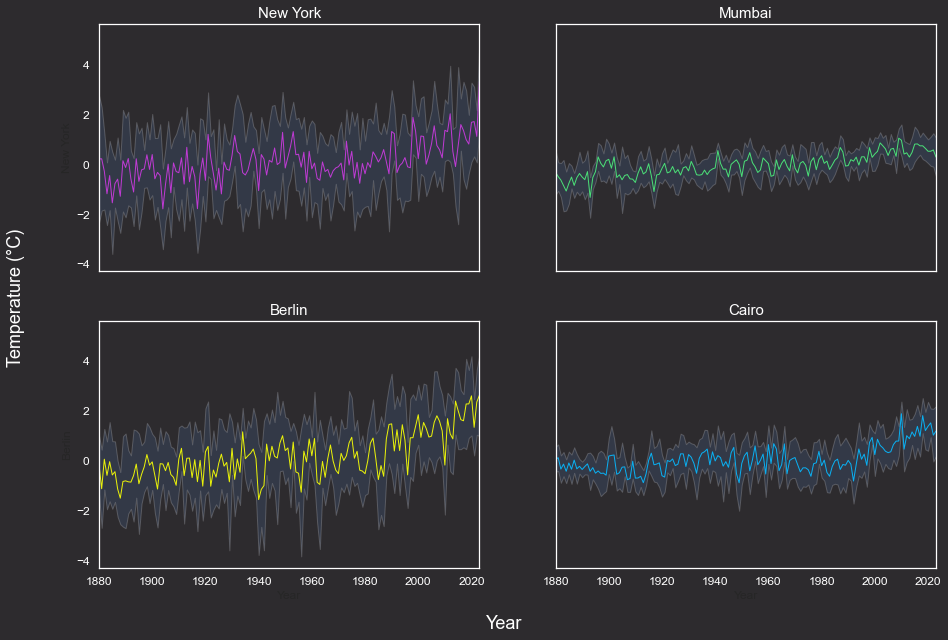

In [7]:
#List of cities for whom plot will be displayed
cities = ['New York','Mumbai','Berlin','Cairo']

#Filter dataframe for selected cities
selected_cities_df = LST_df[LST_df['City'].isin(cities)]

#Calculate mean temperature for each city for every years
city_mean_temps = selected_cities_df.groupby(['Year', 'City'])['Temperature'].mean().unstack()

#Remove year from index and add it as column
city_mean_temps.reset_index(inplace=True)

#Calculate mean temperature for each city for every years
city_std_temps = selected_cities_df.groupby(['Year', 'City'])['Temperature'].std().unstack()

#Remove year from index and add it as column
city_std_temps.reset_index(inplace=True)

#Set figure size, axis background colour for the plot
sns.set(rc={'figure.figsize':(15,10), 'axes.facecolor':'#2d2b2e', 'figure.facecolor':'#2d2b2e'})

#Define total number of subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, sharex = True, sharey = True)

#Set x and y shared axis labels with text formatting.
fig.text(0.5, 0.04, 'Year', ha = 'center', color = 'white', fontsize = 18)
fig.text(0.04, 0.5, 'Temperature (°C)', va = 'center', rotation = 'vertical', color = 'white', fontsize = 18)

#Line Plot of mean temperature vs year
#Plot New York mean Temperature
ax1 = sns.lineplot(data = city_mean_temps, x = 'Year', y = 'New York', color = '#bf3bd4', linewidth = 1, ax = axes[0,0])
#Add standard deviation over the years
ax1.fill_between(city_mean_temps['Year'], city_mean_temps['New York'] - city_std_temps['New York'], 
                 city_mean_temps['New York'] + city_std_temps['New York'], alpha = 0.2, label = 'Standard Deviation')

#Plot Mumbai mean Temperature
ax2 = sns.lineplot(data = city_mean_temps, x = 'Year', y = 'Mumbai', color = '#4bde77', linewidth = 1, ax = axes[0,1])
#Add standard deviation over the years
ax2.fill_between(city_mean_temps['Year'], city_mean_temps['Mumbai'] - city_std_temps['Mumbai'], 
                 city_mean_temps['Mumbai'] + city_std_temps['Mumbai'], alpha = 0.2, label = 'Standard Deviation')

#Plot Berlin mean Temperature
ax3 = sns.lineplot(data = city_mean_temps, x = 'Year', y = 'Berlin', color = '#eaf20a', linewidth = 1, ax = axes[1,0])
#Add standard deviation over the years
ax3.fill_between(city_mean_temps['Year'], city_mean_temps['Berlin'] - city_std_temps['Berlin'], 
                 city_mean_temps['Berlin'] + city_std_temps['Berlin'], alpha = 0.2, label = 'Standard Deviation')

#Plot Cairo mean Temperature
ax4 = sns.lineplot(data = city_mean_temps, x = 'Year', y = 'Cairo', color = '#0ab0f2', linewidth = 1, ax = axes[1,1])
#Add standard deviation over the years
ax4.fill_between(city_mean_temps['Year'], city_mean_temps['Cairo'] - city_std_temps['Cairo'], 
                 city_mean_temps['Cairo'] + city_std_temps['Cairo'], alpha = 0.2, label = 'Standard Deviation')

#For aesthetics
#Set x-axis ticks colour as white and set fontsize to 15.
ax1.tick_params(axis = 'x', colors = 'white', labelsize = 12)
ax2.tick_params(axis = 'x', colors = 'white', labelsize = 12)
ax3.tick_params(axis = 'x', colors = 'white', labelsize = 12)
ax4.tick_params(axis = 'x', colors = 'white', labelsize = 12)

#Set y-axis ticks colour as white and set fontsize to 15.
ax1.tick_params(axis = 'y', colors = 'white', labelsize = 12)
ax2.tick_params(axis = 'y', colors = 'white', labelsize = 12)
ax3.tick_params(axis = 'y', colors = 'white', labelsize = 12)
ax4.tick_params(axis = 'y', colors = 'white', labelsize = 12)

#Set city name as title for each subplot
ax1.set_title('New York', color = 'white', fontsize = 15)
ax2.set_title('Mumbai', color = 'white', fontsize = 15)
ax3.set_title('Berlin', color = 'white', fontsize = 15)
ax4.set_title('Cairo', color = 'white', fontsize = 15)

#Remove grid lines
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax4.grid(False)

#Set limits for x-axis
plt.xlim(1880, 2023)

#Display the plot
plt.show()

### Plot Mean land Surface Temperature Over the Years

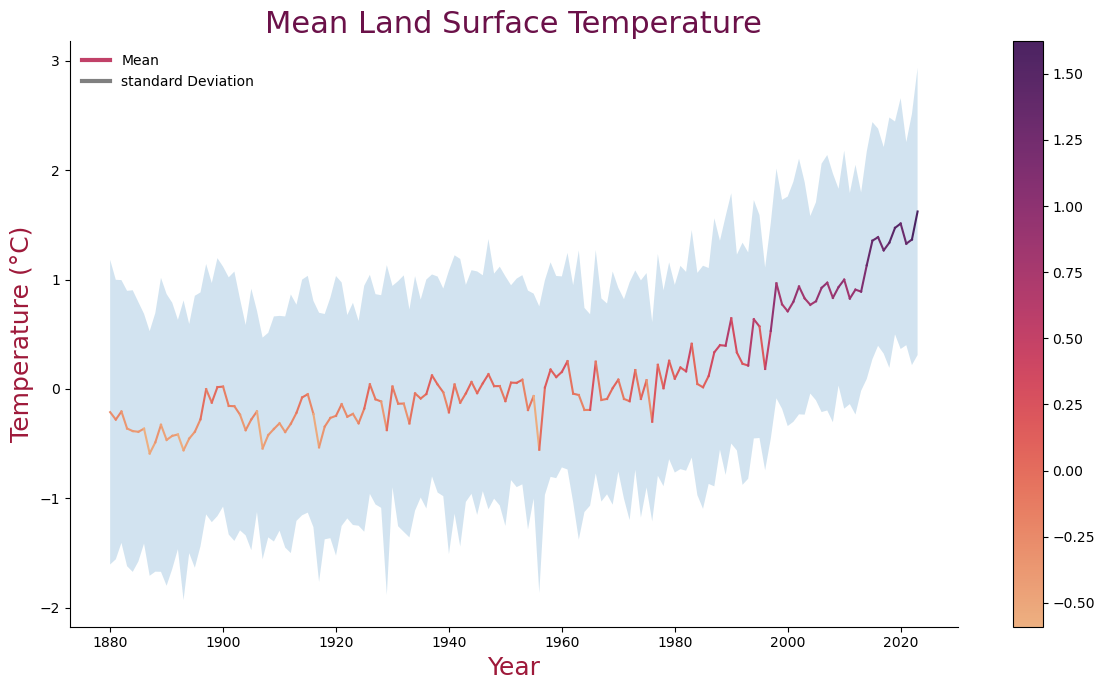

In [8]:
#Calculate mean and standard deviation of temperature for each year.
LST_mean_temp = LST_df.groupby(['Year'])['Temperature'].agg(['mean', 'std']).reset_index()

#Get minimum and maximum mean temperature values
LST_min = LST_mean_temp["mean"].min()
LST_max = LST_mean_temp["mean"].max()

#Create a colormap for positive and negative values
cmap = plt.get_cmap('flare')

#Normalize the temperature values between 0 and 1
nor_temp = (LST_mean_temp['mean'] - LST_mean_temp['mean'].min()) / (LST_mean_temp['mean'].max() - LST_mean_temp['mean'].min())

#Reset formatting to remove previous formatting
mplt.rc_file_defaults()

#Set up the figure and axis
fig, ax = plt.subplots(figsize=(12,7))

#Plot the line graph colored by temperature
for i in range(1, len(LST_mean_temp)):
    ax.plot(LST_mean_temp['Year'][i-1:i+1], LST_mean_temp['mean'][i-1:i+1], color = cmap(nor_temp[i]))

#Add standard deviation for each year by calculating min and max mean using mean - std and mean + std respectively
ax.fill_between(LST_mean_temp['Year'], LST_mean_temp['mean'] - LST_mean_temp['std'], 
                 LST_mean_temp['mean'] + LST_mean_temp['std'], alpha = 0.2, label = 'Standard Deviation')    
    
#Set labels and title
ax.set_xlabel('Year', fontsize = 18, color = "#9e193a")
ax.set_ylabel('Temperature (°C)', fontsize = 18, color = "#9e193a")
ax.set_title('Mean Land Surface Temperature', fontsize = 22, color = "#6b1149")

#Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap = cmap, norm = plt.Normalize(vmin = LST_mean_temp['mean'].min(), vmax = LST_mean_temp['mean'].max()))
cbar = fig.colorbar(sm)

#Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#Create lines to be used as marker in legend
custom_lines = [Line2D([0], [0], color = cmap(0.5), lw = 3),
                Line2D([0], [0], color = 'gray', lw = 3)]

#Add legend with custom markers and labels
plt.legend(custom_lines, ['Mean', 'standard Deviation'], loc = 'upper left', frameon = False)

#Show the plot
plt.grid(False)
plt.tight_layout()

#Save the plot as image on local desktop
#plt.savefig(r'Media\Mean_Land_Surface_Temperature.jpg')

#Display the plot
plt.show()

### Additional Plot to create GIF for Mean Land Surface Temperature Trend over the Years

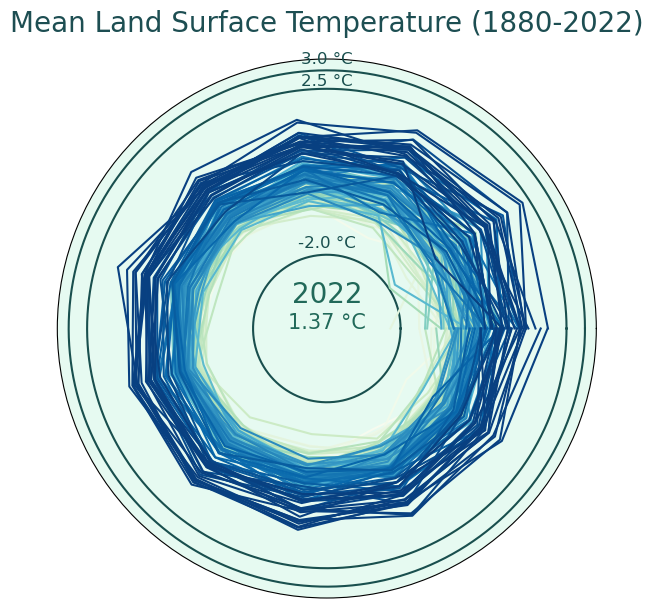

In [9]:
#ALternative plot for Temperature vs Year for LST

#Group the data by date (i.e. monthly) and calculate the mean temperature
LSTP_mean_temp_series = LST_df.groupby('Date')['Temperature'].mean()

#Store result in a dataframe which will be used for plotting
LSTP_mean_temp = pd.DataFrame({'Date':LSTP_mean_temp_series.index, 'Temperature':LSTP_mean_temp_series.values})

#Extract year and month from date
LSTP_mean_temp['Year'] = LSTP_mean_temp['Date'].dt.year
LSTP_mean_temp['Month'] = LSTP_mean_temp['Date'].dt.month

#Remove data for year 2023 since it only contains temperature for 4 months.
LSTP_mean_temp = LSTP_mean_temp.drop(LSTP_mean_temp[LSTP_mean_temp['Year'] == 2023].index)

#Drop date column since it is not usefull
LSTP_mean_temp = LSTP_mean_temp.drop('Date', axis=1)

#Get maximum mean temperature value
LSTP_max = LSTP_mean_temp["Temperature"].max()

#Set figure size and type of plot
fig = plt.figure(figsize=(7,7))
ax1 = plt.subplot(111, projection='polar')

#Remove grid lines
ax1.grid(False)

#Remove x and y axis ticks
ax1.axes.get_yaxis().set_ticklabels([])
ax1.axes.get_xaxis().set_ticklabels([])

#Change background colour
ax1.set_facecolor("#e6faf1")

#Set limit for y-axis
ax1.set_ylim(-4, LSTP_max + 1)

#Create angle theta which indicated angle in radians
theta = np.linspace(0, 2*np.pi, 12)

#Set title of the plot
ax1.set_title("Mean Land Surface Temperature (1880-2022)", color='#1d4e52', fontdict={'fontsize': 20}, pad=20)

#Get all years from the dataframe
years = LSTP_mean_temp['Year'].unique()

#Set values of rho which indicates radius value for each reference lines that will be plot
full_circle_thetas = np.linspace(0, 2*np.pi, 1000)
blue_line_one_radii = [-2.0]*1000
red_line_one_radii = [2.5]*1000
red_line_two_radii = [3.0]*1000

#Add reference lines to the plot for better visualization
ax1.plot(full_circle_thetas, blue_line_one_radii, c='#194f4e')
ax1.plot(full_circle_thetas, red_line_one_radii, c='#194f4e')
ax1.plot(full_circle_thetas, red_line_two_radii, c='#194f4e')

#Loop to plot line for each year
for index, y in enumerate(years):
    #Remove text added for previous line
    for t in ax1.texts:
        t.set_visible(False)
    
    #Get mean temperature value for respective year. It will contain 12 values, 1 for each month that will be used as grid.
    r = LSTP_mean_temp[LSTP_mean_temp['Year'] == y]['Temperature']
    #Get mean temperature value for respective year. This will be a single value.
    Mean_temp = LST_mean_temp[LST_mean_temp['Year'] == y]['mean']
    #Form text that will be displayed
    text = str(round(Mean_temp[index],2)) + ' ' + chr(176) + 'C'
    #Add year, temperature and reference marker text on the plot
    ax1.text(np.pi/2, -4, text, color = '#216959', size = 15, ha = 'center')
    ax1.text(np.pi/2, -3.3, y, color = '#216959', size = 20, ha = 'center')
    ax1.text(np.pi/2, -1.8, "-2.0 " + chr(176) + "C", color = "#194f4e", size = 12, ha = 'center')
    ax1.text(np.pi/2, 2.6, "2.5 " + chr(176) + "C", color = "#194f4e", size = 12, ha = 'center')
    ax1.text(np.pi/2, 3.2, "3.0 " + chr(176) + "C", color = "#194f4e", size = 12, ha = 'center')
    
    #Plot the line with respective theta and rho value
    ax1.plot(theta, r, c = plt.cm.GnBu(index*2))    
    
    #Save image for each year with 'Year' as its name, that will be used to create GIF.
    #plt.savefig(r'Media\Global_Mean_Temp_Images'+ '\\' + str(y)+'.jpg')
    

In [ ]:
#Create GIF for above created images

#Create an empty list
image_frames = []

#Loop for each year
for y in years:
    #Get image for respective year from the folder on local drive
    new_fram = PIL.Image.open(r'Media\Global_Mean_Temp_Images' + '\\' + str(y) + '.jpg') 
    #Add it as a frame in above created list
    image_frames.append(new_fram)

#Load each frame to create GIF
image_frames[0].save('Global_Mean_Temperature_Change.gif', format = 'GIF', append_images = image_frames[1: ],
                    save_all = True, duration = 100, loop = 0)

### Ocean Surface Temperature Data Extraction

Now we will follow same procedure to extract temperature data for Oceans.

In [10]:
#Extract data for all oceans from netcdf file in a dataframe

#Load location for all Oceans from excel file.
ocean_xls = pd.ExcelFile('Ocean_Location.xlsx')
ocean_df = pd.read_excel(ocean_xls)

#Create empty dataframe with date as index
df_oet = pd.DataFrame(0, columns = ['Ocean', 'Temperature', 'Actual_Lat', 'Actual_Lon', 'Nearest_Lat', 'Nearest_Lon'], index = date_range)
#Give index name as 'Date'
df_oet.index.names = ['Date']

#Get size of time variable for iteration during updating temperature
dt_oet = np.arange(0, dataset.variables['time'].size)

#Since number of dates is not equal in empty dataframe and netcdf file, we will extract the commomn date
#Extract time data from netcdf file
time_var_oet = dataset.variables['time']
#Create new dataframe for time which will be used for conversion and comparison
time_df_oet = pd.DataFrame(time_var_oet[:], columns=['masked_date'])
#Convert masked date to 'cftime._cftime.DatetimeGregorian' in a new column
time_df_oet['greg_date'] = nc.num2date(time_var_oet[:], units)

#Function to convert cftime.DatetimeGregorian to pandas datetime
def convert_to_datetime(greg_date):
    return datetime(greg_date.year, greg_date.month, greg_date.day, greg_date.hour, greg_date.minute, greg_date.second)

#Convert 'cftime._cftime.DatetimeGregorian' date to pandas 'datetime'
#Apply the conversion function to the 'greg_date' column and add a new column 'converted_dates'
time_df_oet['converted_dates'] = time_df_oet['greg_date'].apply(convert_to_datetime)
#Change day from 15 to 1
time_df_oet['converted_dates'] = time_df_oet['converted_dates'].apply(lambda x: x.replace(day = 1))

#Check if dates present in NetCDF also exist in the empty dataFrame index i.e. get common dates
matching_dates = []
for date in time_df_oet['converted_dates']:
    if date in df_oet.index:
        matching_dates.append(date)

#Keep only matching dates (rows) in the empty dataframe
df_oet = df_oet[df_oet.index.isin(matching_dates)]

#Initialize a dataframe. It will contain the final dataset
SST_df = pd.DataFrame(columns = ['Date', 'Ocean', 'Temperature', 'Actual_Lat', 'Actual_Lon', 'Nearest_Lat', 'Nearest_Lon'])

#Extract Temperature data for each ocean and store it in 'SST_df'
for oceans in ocean_df.ocean:
    #Get coordinate for each ocean and get temperature data (since there are multiple coordinates for each ocean)
    #Get lat and lon for a coordinate
    ocean_lat = ocean_df.loc[ocean_df['ocean'] == oceans, 'lat'].iloc[0]
    ocean_lon = ocean_df.loc[ocean_df['ocean'] == oceans, 'lon'].iloc[0]
    
    #Calculate Squared distance between Ocean location and location present in netcdf grid (i.e. choose the nearest point)
    sq_diff_lat = (lat - ocean_lat)**2
    sq_diff_lon = (lon - ocean_lon)**2

    #Get index of minimum value (i.e. smalleest squared distance)
    lat_index = sq_diff_lat.argmin()
    lon_index = sq_diff_lon.argmin()
    
    #Update temperature for specific coordinate in empty dataframe
    for time_index in dt_oet:
        df_oet.iloc[time_index] = oceans, temp[time_index, lat_index, lon_index], ocean_lat, ocean_lon, lat[lat_index], lon[lon_index]
        
    #Create new dataframe to store result
    df1_oet = df_oet.copy()
    #Convert index to column so that date can be a present as column
    df1_oet.reset_index(inplace=True)
    #Concate all the data
    SST_df = pd.concat([SST_df, df1_oet], axis=0, ignore_index=True)
    
#Remove NA values (i.e. -99 updated above) from the dataset.
SST_df = SST_df.loc[SST_df["Temperature"] != -99]

#Display final dataframe containing Sea Surface Temperature data.
SST_df

,Date,Ocean,Temperature,Actual_Lat,Actual_Lon,Nearest_Lat,Nearest_Lon
0,1880-01-01,North Atlantic Ocean,1.43,38.706859,-62.530453,39,-63
1,1880-02-01,North Atlantic Ocean,0.71,38.706859,-62.530453,39,-63
2,1880-03-01,North Atlantic Ocean,0.52,38.706859,-62.530453,39,-63
3,1880-04-01,North Atlantic Ocean,1.24,38.706859,-62.530453,39,-63
4,1880-05-01,North Atlantic Ocean,0.56,38.706859,-62.530453,39,-63
...,...,...,...,...,...,...,...
75675,2022-12-01,South Pacific Ocean,-0.07,-13.983871,-92.149598,-13,-93
75676,2023-01-01,South Pacific Ocean,0.67,-13.983871,-92.149598,-13,-93
75677,2023-02-01,South Pacific Ocean,0.88,-13.983871,-92.149598,-13,-93
75678,2023-03-01,South Pacific Ocean,1.50,-13.983871,-92.149598,-13,-93


**Calculate yearwise summary statistics for ocean surface temperature data.**

In [11]:
#Extract the year from the 'Date' column which will be used to calculate mean temperature by year
SST_df['Year'] = SST_df['Date'].dt.year

#Group by 'Year' and 'Ocean' (Location) , to calculate mean, standard deviation, maximum and minimum of temperature for each year.
SST_Temp_df = SST_df.groupby(['Year', 'Ocean'])['Temperature'].agg(['mean', 'std', 'max', 'min']).reset_index()
SST_Temp_df.head(10)

,Year,Ocean,mean,std,max,min
0,1880,Indian Ocean,-0.785833,0.403823,-0.41,-1.60
1,1880,North Atlantic Ocean,0.469167,0.514177,1.43,-0.36
2,1880,North Pacific Ocean,-0.363333,0.962970,1.33,-1.89
3,1880,South Atlantic Ocean,-0.511667,0.243858,-0.09,-0.83
4,1880,South Pacific Ocean,0.363333,0.533186,1.16,-0.64
5,1881,Indian Ocean,-0.092500,0.309924,0.24,-0.64
6,1881,North Atlantic Ocean,-0.333333,0.536865,0.61,-1.06
7,1881,North Pacific Ocean,0.094167,1.131235,2.07,-1.49
8,1881,South Atlantic Ocean,0.133333,0.406916,0.74,-0.68
9,1881,South Pacific Ocean,-0.098333,0.199584,0.20,-0.35


**For plotting, calculate mean temperature for all ocean seperately**

In [12]:
#Create Yearwise mean temperature for each ocean in a new column

#Calculate mean temperature for each city for every years
ocean_mean_temps = SST_df.groupby(['Year', 'Ocean'])['Temperature'].mean().unstack()

#Remove year from index and add it as column
ocean_mean_temps.reset_index(inplace=True)

#Calculate standard deviation of temperature yearwise for each city
ocean_std_temps = SST_df.groupby(['Year', 'Ocean'])['Temperature'].std().unstack()

#Remove year from index and add it as column
ocean_std_temps.reset_index(inplace=True)
ocean_std_temps.tail()

Ocean,Year,Artic Ocean,Indian Ocean,North Atlantic Ocean,North Pacific Ocean,South Atlantic Ocean,South Pacific Ocean
139,2019,1.500222,0.304990,0.338619,0.479321,0.366287,0.269693
140,2020,2.427817,0.248781,0.461858,0.291659,0.364483,0.450661
141,2021,2.321146,0.239256,0.391132,0.572066,0.305854,0.289870
142,2022,2.043698,0.180904,0.232587,0.604906,0.169200,0.171561
143,2023,1.260748,0.434066,0.267111,0.291111,0.133731,0.419098


### Data Visualization for Ocean Temperature Trend over the years

Plot mean surface temperature vs year for each ocean in a 3x2 single plot.

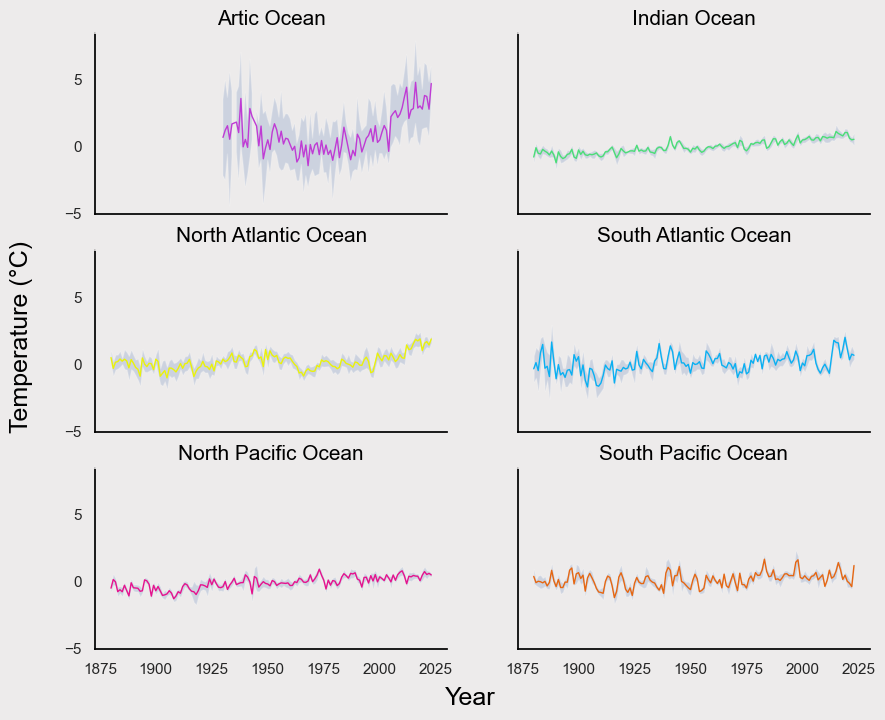

In [13]:
#Set figure size, axis background colour for the plot
sns.set(rc={'figure.figsize':(10,8), 'axes.facecolor':'#edebeb', 'figure.facecolor':'#edebeb'})

#Define number of subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, sharex = True, sharey = True)
#Set x and y shared axis labels with text formatting.
fig.text(0.5, 0.04, 'Year', ha = 'center', color = 'black', fontsize = 18)
fig.text(0.04, 0.5, 'Temperature (°C)', va = 'center', rotation = 'vertical', color = 'black', fontsize = 18)

#Line Plot for each ocean in different subplots
#Plot Artic Ocean mean Temperature
ax1 = sns.lineplot(data = ocean_mean_temps, x = 'Year', y = 'Artic Ocean', color = '#bf3bd4', linewidth = 1, ax = axes[0,0])
#Plot Standard deviation over the years
ax1.fill_between(ocean_std_temps['Year'], ocean_mean_temps['Artic Ocean'] - ocean_std_temps['Artic Ocean'], 
                 ocean_mean_temps['Artic Ocean'] + ocean_std_temps['Artic Ocean'], alpha = 0.2, label = 'Standard Deviation')

#Plot Indian Ocean mean Temperature
ax2 = sns.lineplot(data = ocean_mean_temps, x = 'Year', y = 'Indian Ocean', color = '#4bde77', linewidth = 1, ax = axes[0,1])
#Plot Standard deviation over the years
ax2.fill_between(ocean_std_temps['Year'], ocean_mean_temps['Indian Ocean'] - ocean_std_temps['Indian Ocean'], 
                 ocean_mean_temps['Indian Ocean'] + ocean_std_temps['Indian Ocean'], alpha = 0.2, label = 'Standard Deviation')

#Plot North Atlantic Ocean mean Temperature
ax3 = sns.lineplot(data = ocean_mean_temps, x = 'Year', y = 'North Atlantic Ocean', color = '#eaf20a', linewidth = 1, ax = axes[1,0])
#Plot Standard deviation over the years
ax3.fill_between(ocean_std_temps['Year'], ocean_mean_temps['North Atlantic Ocean'] - ocean_std_temps['North Atlantic Ocean'], 
                 ocean_mean_temps['North Atlantic Ocean'] + ocean_std_temps['North Atlantic Ocean'], alpha = 0.2, label = 'Standard Deviation')

#Plot North Pacific Ocean mean Temperature
ax4 = sns.lineplot(data = ocean_mean_temps, x = 'Year', y = 'North Pacific Ocean', color = '#0ab0f2', linewidth = 1, ax = axes[1,1])
#Plot Standard deviation over the years
ax4.fill_between(ocean_std_temps['Year'], ocean_mean_temps['North Pacific Ocean'] - ocean_std_temps['North Pacific Ocean'], 
                 ocean_mean_temps['North Pacific Ocean'] + ocean_std_temps['North Pacific Ocean'], alpha = 0.2, label = 'Standard Deviation')

#Plot South Atlantic Ocean mean Temperature
ax5 = sns.lineplot(data = ocean_mean_temps, x = 'Year', y = 'South Atlantic Ocean', color = '#e6128e', linewidth = 1, ax = axes[2,0])
#Plot Standard deviation over the years
ax5.fill_between(ocean_std_temps['Year'], ocean_mean_temps['South Atlantic Ocean'] - ocean_std_temps['South Atlantic Ocean'], 
                 ocean_mean_temps['South Atlantic Ocean'] + ocean_std_temps['South Atlantic Ocean'], alpha = 0.2, label = 'Standard Deviation')

#Plot South Pacific Ocean mean Temperature
ax6 = sns.lineplot(data = ocean_mean_temps, x = 'Year', y = 'South Pacific Ocean', color = '#e66712', linewidth = 1, ax = axes[2,1])
#Plot Standard deviation over the years
ax6.fill_between(ocean_std_temps['Year'], ocean_mean_temps['South Pacific Ocean'] - ocean_std_temps['South Pacific Ocean'], 
                 ocean_mean_temps['South Pacific Ocean'] + ocean_std_temps['South Pacific Ocean'], alpha = 0.2, label = 'Standard Deviation')

#For aesthetics
#Set x-axis labels colour
ax1.xaxis.label.set_color('#edebeb')
ax1.yaxis.label.set_color('#edebeb')
ax2.xaxis.label.set_color('#edebeb')
ax2.yaxis.label.set_color('#edebeb')
ax3.xaxis.label.set_color('#edebeb')
ax3.yaxis.label.set_color('#edebeb')
ax4.xaxis.label.set_color('#edebeb')
ax4.yaxis.label.set_color('#edebeb')
ax5.xaxis.label.set_color('#edebeb')
ax5.yaxis.label.set_color('#edebeb')
ax6.xaxis.label.set_color('#edebeb')
ax6.yaxis.label.set_color('#edebeb')

#Set y-axis colour to gray and black for each subplot.
ax1.spines['top'].set_color('#edebeb')
ax1.spines['bottom'].set_color('black')
ax1.spines['right'].set_color('#edebeb')
ax1.spines['left'].set_color('black')

ax2.spines['top'].set_color('#edebeb')
ax2.spines['bottom'].set_color('black')
ax2.spines['right'].set_color('#edebeb')
ax2.spines['left'].set_color('black')

ax3.spines['top'].set_color('#edebeb')
ax3.spines['bottom'].set_color('black')
ax3.spines['right'].set_color('#edebeb')
ax3.spines['left'].set_color('black')

ax4.spines['top'].set_color('#edebeb')
ax4.spines['bottom'].set_color('black')
ax4.spines['right'].set_color('#edebeb')
ax4.spines['left'].set_color('black')

ax5.spines['top'].set_color('#edebeb')
ax5.spines['bottom'].set_color('black')
ax5.spines['right'].set_color('#edebeb')
ax5.spines['left'].set_color('black')

ax6.spines['top'].set_color('#edebeb')
ax6.spines['bottom'].set_color('black')
ax6.spines['right'].set_color('#edebeb')
ax6.spines['left'].set_color('black')

#Add Ocean Name as title to each subplot
ax1.set_title('Artic Ocean', color = 'black', fontsize = 15)
ax2.set_title('Indian Ocean', color = 'black', fontsize = 15)
ax3.set_title('North Atlantic Ocean', color = 'black', fontsize = 15)
ax4.set_title('South Atlantic Ocean', color = 'black', fontsize = 15)
ax5.set_title('North Pacific Ocean', color = 'black', fontsize = 15)
ax6.set_title('South Pacific Ocean', color = 'black', fontsize = 15)

#Remove grid lines
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax4.grid(False)
ax5.grid(False)
ax6.grid(False)

#Display the plot
plt.show()

### Plot Mean Ocean Surface Temperature Over the Years

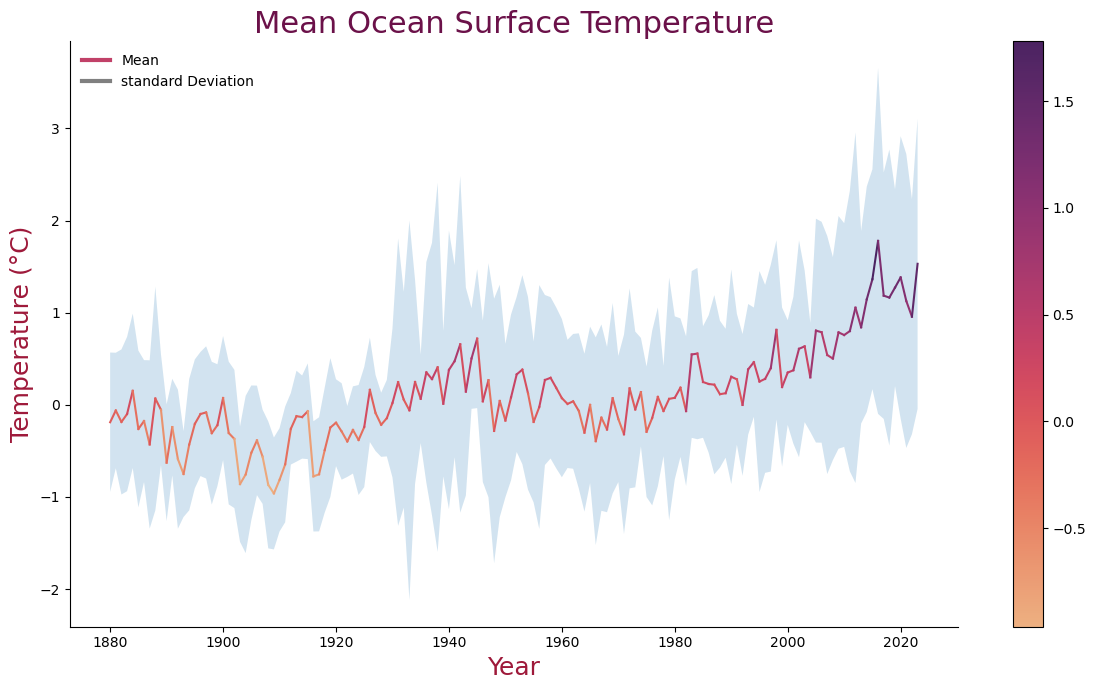

In [14]:
#Calculate mean and standard deviation of temperature for each year.
SST_stat_df = SST_df.groupby(['Year'])['Temperature'].agg(['mean', 'std']).reset_index()

#Reset formatting to remove previous formatting
mplt.rc_file_defaults()

#Create a colormap for positive and negative values
cmap = plt.get_cmap('flare')

#Normalize the temperature values between 0 and 1
normalized_temp = (SST_stat_df['mean'] - SST_stat_df['mean'].min()) / (SST_stat_df['mean'].max() - SST_stat_df['mean'].min())

#Set up the figure and axis
fig, ax = plt.subplots(figsize=(12,7))

#Plot the line graph colored by temperature
for i in range(1, len(SST_stat_df)):
    ax.plot(SST_stat_df['Year'][i-1:i+1], SST_stat_df['mean'][i-1:i+1], color = cmap(normalized_temp[i]), label = 'Mean Temperature')
    
#Add standard deviation for each year by calculating min and max mean using mean - std and mean + std respectively
ax.fill_between(SST_stat_df['Year'], SST_stat_df['mean'] - SST_stat_df['std'], 
                 SST_stat_df['mean'] + SST_stat_df['std'], alpha = 0.2, label = 'Standard Deviation')

#Set labels and title
ax.set_xlabel('Year', fontsize = 18, color = "#9e193a")
ax.set_ylabel('Temperature (°C)', fontsize = 18, color = "#9e193a")
ax.set_title('Mean Ocean Surface Temperature', fontsize = 22, color = "#6b1149")

#Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap = cmap, norm = plt.Normalize(vmin = SST_stat_df['mean'].min(), vmax = SST_stat_df['mean'].max()))
cbar = fig.colorbar(sm)

#Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#Create lines to be used as marker in legend
custom_lines = [Line2D([0], [0], color = cmap(0.5), lw = 3),
                Line2D([0], [0], color = 'gray', lw = 3)]

#Add legend with custom markers and labels
plt.legend(custom_lines, ['Mean', 'standard Deviation'], loc = 'upper left', frameon = False)

#Show the plot
plt.grid(False)
plt.tight_layout()

#Save the plot as image on local desktop
#plt.savefig(r'Media\Mean_Ocean_Surface_Temperature.jpg')

#Display the plot
plt.show()

### Global Mean Surface Temperature

Combine Land and Ocean Surface Temperature data to get Global Surface Temperature dataset.

In [16]:
#Combine Land and Ocean Surface Temperature data
GST_df = pd.concat([LST_df, SST_df], ignore_index=True)

#Calculate mean temperature per year for this combined dataset
GST_mean_df = GST_df.groupby('Year')['Temperature'].mean().reset_index()

#Extract temperature data from .netcdf file which will be used for plotting this GIF only
temp = dataset.variables['tempanomaly'][:]

#Calculate Mean Temperature
lst_mean = np.mean(temp, axis = 0)

#Define range of latitude and longitude
lat_range = [6, 10, 20, 30, 40, 50, 60, 70, 80, 70, 60, 50, 40, 30, 20, 10, 0, -10, -20, -30, -40, -50, -40, -30, -20, -10, -6]
lon_range = [30, 40, 50, 75, 87, 100, 113, 125, 137, 150, 163, 175, -163, -150, -137, -125, -113, -100, -87, -75, -63, -50, -40, -30, -20, 0, 15]

#Define a range of latitude and longitude on which globe will rotate
range_df = pd.DataFrame({'lat' : lat_range, 'lon' : lon_range})

#Plot the graphs for defined range
for i in range(0, len(range_df) - 1):
    
    #Create figure for globe projection
    fig = plt.figure(figsize = (10, 6))

    #Set title for the plot
    plt.title('Global Mean Surface Temperature', fontsize = 12)
    
    #Set the side of globe to be displayed based on latitude and longitude
    ax = plt.axes(projection = ccrs.Orthographic(central_latitude = range_df.lat[i], central_longitude = range_df.lon[i]))
    
    #Plot the global mean surface temperature data on the globe
    img = ax.imshow(lst_mean, origin = 'lower', extent = [-180, 180, -90, 90], cmap = mplt.colormaps['Spectral'], transform = ccrs.PlateCarree(), interpolation = 'catrom')
    
    #Add coastlines and gridlines
    ax.coastlines(color = 'black', linewidth = 0.7)
    ax.add_feature(cfeature.BORDERS, edgecolor = 'white', linewidth = 0.25)
    ax.gridlines()

    #Add colorbar and title for it
    cbar = plt.colorbar(img, ax = ax, shrink = 0.7)
    cbar.set_label('Temperature')
    
    #Save each plot as image on local drive
    plt.savefig(r'Media\Globe_Mean_Temp_Images'+ '\\' + str(i) +'.jpg')
    
    plt.close()

In [17]:
import PIL

#Create an empty list
image_frames = []

#Loop for each year
for i in range(0,len(range_df) - 1):
    #Get image for respective year from the folder on local drive
    new_fram = PIL.Image.open(r'Media\Globe_Mean_Temp_Images' + '\\' + str(i) + '.jpg') 
    #Add it as a frame in above created list
    image_frames.append(new_fram)

#Load each frame to create GIF
image_frames[0].save('Globe_Mean_Temperature.gif', format='GIF', append_images = image_frames[1: ], save_all = True, 
                     duration = 150, loop = 0)

# Correlation Between Temperature and CO2

In [18]:
#Load CO2 data from excel file
co2_xls = pd.ExcelFile('Global_CO2.xlsx')
co2_df = pd.read_excel(co2_xls, 'Data', skiprows = 4, usecols = [1,2], names = ['Year', 'CO2'])

#Update value as '2022' instead of '2022*' (original value)
co2_df.at[63,'Year'] = '2022'

#Convert Year to integer to be used during merging
co2_df['Year'] = co2_df['Year'].astype(int)

#Combine Land Surface Temperature and CO2 datasets to find coorelation
combined_df = pd.merge(GST_mean_df, co2_df, on = "Year", how = 'inner')
combined_df.head()

,Year,Temperature,CO2
0,1959,0.131898,315.98
1,1960,0.130642,316.91
2,1961,0.179416,317.64
3,1962,-0.018200,318.45
4,1963,-0.058559,318.99


### Plot for Atmospheric Carbon Dioxide Emission Over the Years

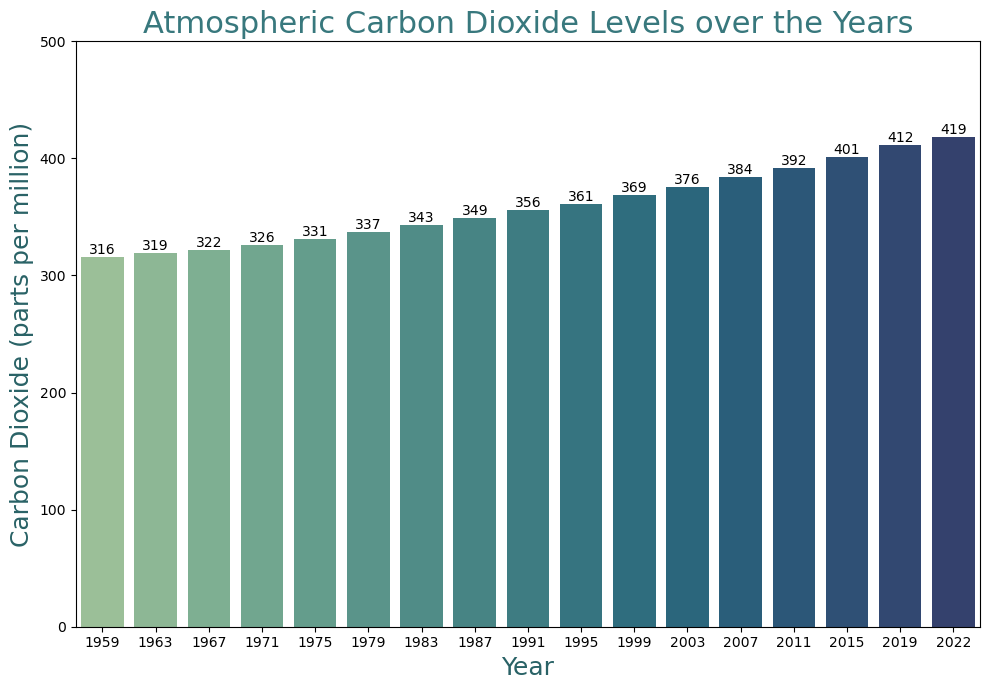

In [19]:
#Get 15 equally spreaded years from the dataset
subset_df = co2_df.iloc[::len(co2_df) // 15]

#TO add data for year 2022, create it as a second dataframe
new_row = {'Year': 2022, 'CO2': co2_df[co2_df['Year'] == 2022].iloc[0,1]}

#Convert it to a DataFrame
new_row_df = pd.DataFrame([new_row])

#Add this dataframe to the actual dataFrame
subset_df = pd.concat([subset_df, new_row_df], ignore_index=True)

#Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,7))

#Set custom color palette for bar colour
custom_palette = sns.color_palette("crest", n_colors=len(subset_df))

#Plot bar chart of Year vs CO2 levels
bar = sns.barplot(data = subset_df, x = 'Year', y = 'CO2', palette = custom_palette)

#Add CO2 values at the top of each bar
for idx, rect in enumerate(bar.patches):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha = 'center', va = 'bottom')

#Set labels and title
plt.xlabel('Year', fontsize = 18, color = "#296266")
plt.ylabel('Carbon Dioxide (parts per million)', fontsize = 18, color = "#296266")
plt.title('Atmospheric Carbon Dioxide Levels over the Years', fontsize = 22, color = "#38787d")
    
#Set limits for y-axis    
plt.ylim(0, 500)

#Remove grid lines
plt.grid(False)
plt.tight_layout()

#Save plot as image on local drive
#plt.savefig(r'Media\Atmospheric_Co2.jpg')

#Display the plot
plt.show()

### Correlation Between Temperature and CO2

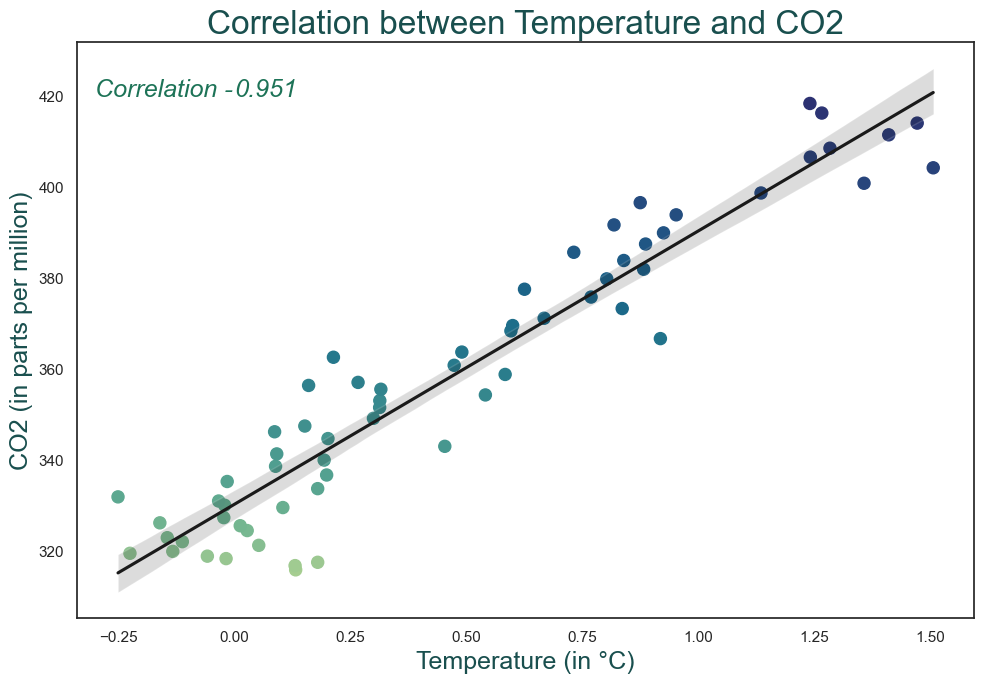

In [20]:
#Find correlation between temperature and CO2
correlation = np.corrcoef(combined_df.Temperature, combined_df.CO2)

#Scatter Plot of Temperature vs CO2
sns.set(rc={'figure.figsize':(10,7)})

#Set background as white
sns.set_style(style = 'white')

#Add points on the plot
plt.scatter(x = combined_df["Temperature"], y = combined_df["CO2"], c = combined_df["Year"], s = 75, cmap = "crest")

#Add an regression line displaying the correlation
sns.regplot(x = "Temperature", y = "CO2", data = combined_df, scatter = False, color = ".1")

#Add correlation value as text on the plot
plt.text(-0.30, 420, "Correlation - ", fontsize = 18, fontstyle = "oblique", ha = "left", color = "#1d7357")
plt.text(0.0, 420, round(correlation[0,1],4), fontsize = 18, fontstyle = "oblique", ha = "left", color = "#1d7357")

#Add x, y-axis labels and title
plt.xlabel("Temperature (in " + chr(176) + "C)", fontsize = 18, color = "#194f4e")
plt.ylabel("CO2 (in parts per million)", fontsize = 18, color = "#194f4e")
plt.title("Correlation between Temperature and CO2", fontsize = 24, color = "#194f4e")

#Use tight layout
plt.tight_layout()

#Save plot as image on local drive
#plt.savefig(r'Media\Temp_CO2_Correlation.jpg')

#Display the plot
plt.show()

# Role of Volcanic Eruptions in Rising CO2

The substantial volume of CO2 emissions has reached a level where sensors struggle to differentiate between CO2 originating from volcanic sources and CO2 generated by human activities. As a consequences, there is currently a lack of available data specifically attributing CO2 emissions to volcanic sources. Hence we conducted a data modelling procedure to derive estimations of CO2 emissions originating from volcanic activities.

## Data Collection and Integration

We have dataset containing amount of sulpher dioxide released during volcanic eruptions. Also we have CS ratio for few volcanos which is the ratio of amount of carbon dioxide per sulpher dioxide present in gases released during respective volanic eruption. Hence we need to predict missing CS values using a statistical machine learning model. For this, we need to prepare data before passing it as input to the regression model. 

In [21]:
#Read Volcano Eruption data with attributes as SO2 emission, Year of eruption, Volcanic Explositivity Index from txt file. #1978 - 2022
SO2_VED = pd.read_csv('SO2_MSVOLSO2L4.4_MSVOLSO2L4_v04-00-2022m0505.txt', sep = '\t', skiprows = 47, usecols = [0,1,2,3,4,5,6,7,8,9,10,11], on_bad_lines='skip')

#Create new datdframe
SO2_SOVEI_df = pd.DataFrame({'Volcano' : SO2_VED.volcano, 'Year' : SO2_VED.yyyy,'SO2' : SO2_VED['so2(kt)'], 'VEI' : SO2_VED.vei})
SO2_SOVEI_df.tail()

,Volcano,Year,SO2,VEI
2198,Manam,2022,10.0,3
2199,Karymsky,2022,8.0,3
2200,Krakatau,2022,6.0,2
2201,Krakatau,2022,12.0,2
2202,Krakatau,2022,10.0,2


In [22]:
#Read Volcanic Cardon dioxide to sulpher dioxide data (CS ratio) from excel file.
SO2_xls = pd.ExcelFile('1445-1_ECL_Fischer_et_al_volatiles_volcanoes.xlsx')
SO2_CS_df = pd.read_excel(SO2_xls, 'Volatile emissions', skiprows = 10, usecols = [1,8,16,18,20], names = ['Name', 'So2', 'CS_17', 'PCS_19', 'PCSG_19'])

#Add additional column that will contain c/s ratio if any one of the value is null in another cs columns.
SO2_CS_df['CS'] = SO2_CS_df['CS_17'].fillna(SO2_CS_df['PCS_19']).fillna(SO2_CS_df['PCSG_19'])

#Convert name to Uppercase which will be used for updating values in main dataframe
SO2_SOVEI_df['Uppercase Name'] = SO2_SOVEI_df['Volcano'].str.upper()

#Merge the dataframes based on matching names and keep all rows from left 'SO2_SOVEI_df' dataframe
SO2_PAR_df = pd.merge(SO2_SOVEI_df, SO2_CS_df, left_on = 'Uppercase Name', right_on = 'Name', how = 'left')

#Drop unwanted columns
SO2_PAR_df = SO2_PAR_df.drop(columns=['Uppercase Name', 'Name', 'So2', 'CS_17', 'PCS_19', 'PCSG_19'])
SO2_PAR_df.tail()

,Volcano,Year,SO2,VEI,CS
2198,Manam,2022,10.0,3,2.7
2199,Karymsky,2022,8.0,3,1.2
2200,Krakatau,2022,6.0,2,0.4
2201,Krakatau,2022,12.0,2,0.4
2202,Krakatau,2022,10.0,2,0.4


In [23]:
#Read volcano eruption details such as volcano type, evelation, tectonic settings and debres composition data from excel file.
SO2_add_xls = pd.ExcelFile('GVP_Volcano_List.xlsx')
SO2_ADD_df = pd.read_excel(SO2_add_xls, skiprows = 1, usecols = [1,2,9,10,12,13], names = ['Name', 'Type', 'Elevation', 'Tectonic_Settings', 'Major_Rock_1', 'Major_Rock_2'])

#Filter volcanos whose name is present in actual dataframe
SO2_FADD_df = SO2_ADD_df[SO2_ADD_df['Name'].isin(SO2_PAR_df.Volcano.unique())]
    
#Drop rows with null values in the 'Elevation' column
SO2_FADD_df = SO2_FADD_df.dropna(subset=['Elevation'])

#Merge the dataframes based on matching names
SO2_df = pd.merge(SO2_PAR_df, SO2_FADD_df, left_on='Volcano', right_on='Name', how = 'left')

#Drop unwanted columns
SO2_df = SO2_df.drop(columns=['Name'])

#Drop rows which have NA values for SO2
SO2_df = SO2_df.dropna(subset=['SO2'])

#Update -999 to zero for VEI column
SO2_df.loc[SO2_df['VEI'] == -999, 'VEI'] = 0

#Fill NA values with zero for Elevation column
SO2_df['Elevation'] = SO2_df['Elevation'].fillna(0)

SO2_df.tail()

,Volcano,Year,SO2,VEI,CS,Type,Elevation,Tectonic_Settings,Major_Rock_1,Major_Rock_2
2198,Manam,2022,10.0,3,2.7,Stratovolcano,1807.0,Subduction zone / Continental crust (>25 km),Basalt / Picro-Basalt,Andesite / Basaltic Andesite
2199,Karymsky,2022,8.0,3,1.2,Stratovolcano,1513.0,Subduction zone / Continental crust (>25 km),Andesite / Basaltic Andesite,Dacite
2200,Krakatau,2022,6.0,2,0.4,Caldera,155.0,Subduction zone / Continental crust (>25 km),Andesite / Basaltic Andesite,Dacite
2201,Krakatau,2022,12.0,2,0.4,Caldera,155.0,Subduction zone / Continental crust (>25 km),Andesite / Basaltic Andesite,Dacite
2202,Krakatau,2022,10.0,2,0.4,Caldera,155.0,Subduction zone / Continental crust (>25 km),Andesite / Basaltic Andesite,Dacite


## Data Preprocessing

Perform One-hot encoding, split data into training, validation, test sets and standardize numerical variables.

In [24]:
#Load required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#Create a copy of main dataframe
BELR_df = SO2_df.copy()

#Separate categorical variables to have lookups as column containing binary values using One-hot encode
LR_df = pd.get_dummies(BELR_df, columns=['Type', 'Tectonic_Settings', 'Major_Rock_1', 'Major_Rock_2'])

#Get list of columns which will be used a explanatory variables. CS value will be predicted. Volcano Name and Year are not required.
predictors = [col for col in LR_df.columns if (col != 'CS' and col != 'Volcano' and col != 'Year')]

#Use all records which do not contain any null values (i.e. in CS column) in training set.
train = LR_df[LR_df.iloc[:, 0:].notna().all(axis=1)]
#Separate response and predictor variables for training set
x = train[predictors]
y = train['CS']

#Split x into training and validation sets with 80-20 ratio.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state=42)

#All records with null values for CS will be used in test set since we need to predict values for these records.
test = LR_df[LR_df.iloc[:, 0:].isnull().any(axis=1)]
#Separate response and predictor variables for testing set
x_test = test[predictors]
y_test = test['CS']

#Initialize StandardScaler
scaler = StandardScaler()

#Standardize the datasets
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

### Model Development and Training

We will implement RandomForest regression model with K-fold as cross-validation technique (5 folds). 

In [25]:
#Initialize K-fold with 5 folds with 42 as seed to reproduce the same results
num_folds = 5
kf = KFold(n_splits = num_folds, shuffle = True, random_state = 42)

#Initialize the Random Forest Regression model
model = RandomForestRegressor(n_estimators = 50, random_state = 10)

#Initialize a list to store root mean squared error for each fold
rmse_scores = []

#Perform k-fold cross-validation
for train_idx, val_idx in kf.split(x_train_scaled):
    #Get subset from training and validation set for training
    x_train_fold, x_val_fold = x_train_scaled[train_idx], x_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    #Fit the model using training set
    model.fit(x_train_fold, y_train_fold)

    #Make prediction on validation set
    y_pred_krfe = model.predict(x_val_fold)

    #Calculate RMSE for the fold
    rmse = mean_squared_error(y_val_fold, y_pred_krfe, squared = False)
    
    #Store RMSE in a list
    rmse_scores.append(rmse)

### Model Evaluation

In [26]:
#Calculate the average RMSE
average_rmse = sum(rmse_scores) / num_folds

#Display the result
print(f"Average RMSE across {num_folds} folds: {average_rmse}")

Average RMSE across 5 folds: 1.336056032931014


### Prediction and Volcanic CO2 Calculation

In [27]:
#Train the model on the full training set
model.fit(x_train_scaled, y_train)

#Make Prediction on test set
y_test_pred_krfe = model.predict(x_test_scaled)

#Make copy of actual dataframe
CO2_vol_df = SO2_df.copy()

#Update predicted 'CS' values in the actual dataset based on row index
for i, cs_value in zip(test.index, y_test_pred_krfe):
    CO2_vol_df.loc[i, 'CS'] = cs_value
    
#Calculate CO2 by multiplying SO2 and CS ratio to get values in Kiloton
CO2_vol_df['CO2'] = CO2_vol_df['SO2'] * CO2_vol_df['CS']

#Calculate mean CO2 emitted by volcanos in each year
CO2_vol_mean = CO2_vol_df.groupby('Year')['CO2'].mean().reset_index()

#Convert kilton to gigaton by dividing it by 10,00,000
CO2_vol_mean['CO2_VOL_GT'] = CO2_vol_mean['CO2'] / 1000000

#Display the result
CO2_vol_mean.tail()

,Year,CO2,CO2_VOL_GT
39,2018,267.010370,0.000267
40,2019,580.800089,0.000581
41,2020,25.997613,0.000026
42,2021,45.489526,0.000045
43,2022,78.172182,0.000078


In [28]:
#Convert atmospheric CO2 (parts per million) to Gigaton
co2_df['CO2_ATM_GT'] = co2_df['CO2'] * 7.8

#Display the result
co2_df.tail()

,Year,CO2,CO2_ATM_GT
59,2018,408.72,3188.016
60,2019,411.66,3210.948
61,2020,414.24,3231.072
62,2021,416.45,3248.310
63,2022,418.56,3264.768


### Conversions and Visualizations

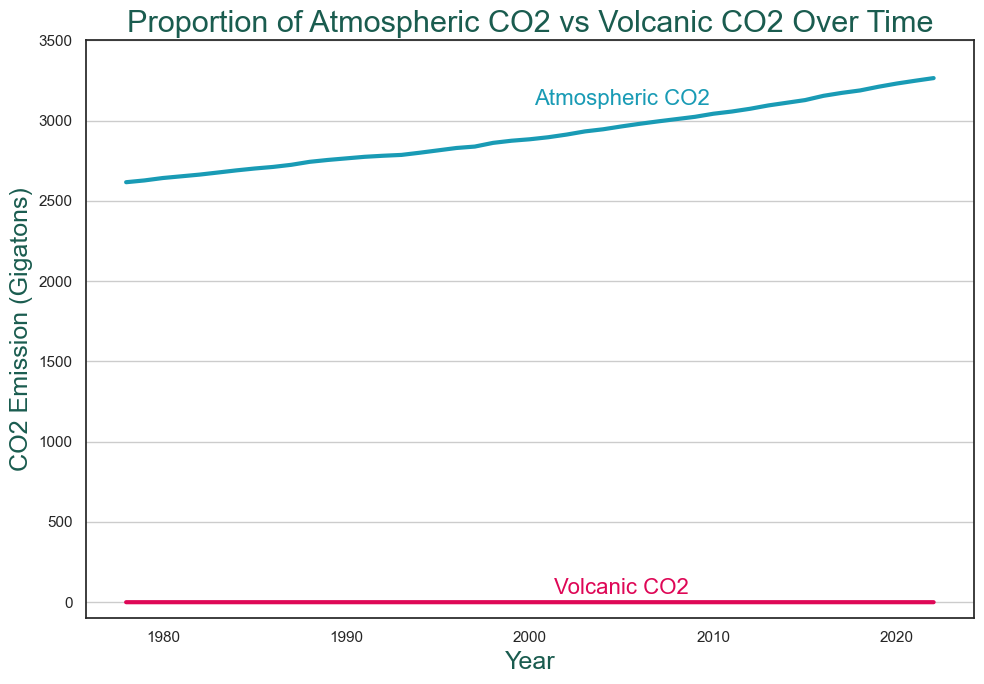

In [29]:
#Combine the above two dataframe to get new dataframe which will be used for plotting
CO2_plot_df = pd.merge(co2_df, CO2_vol_mean, on = "Year", how = 'inner')

#Set figure size and background colour for the plot
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style(style = 'white')

#Line Plot of atmospheric CO2 vs year
sns.lineplot(data = CO2_plot_df, x = 'Year', y = 'CO2_ATM_GT', color = '#199bb5', linewidth = 3)
#Add text to differentiate between two CO2 emissions
plt.text(2005, 3100, 'Atmospheric CO2', color = '#199bb5', size = 16, ha = 'center')

#Line Plot of volcanic CO2 vs year
sns.lineplot(data = CO2_plot_df, x = 'Year', y = 'CO2_VOL_GT', color = '#de0756', linewidth = 3)
#Add text to differentiate between two CO2 emissions
plt.text(2005, 50, 'Volcanic CO2', color = '#de0756', size = 16, ha = 'center')

#Set labels and title
plt.xlabel('Year', fontsize = 18, color = "#1a5c4f")
plt.ylabel('CO2 Emission (Gigatons)', fontsize = 18, color = "#1a5c4f")
plt.title('Proportion of Atmospheric CO2 vs Volcanic CO2 Over Time', fontsize = 22, color = "#1a5c4f")
    
#Set limit for y-axiss
plt.ylim(-100, 3500)

#Display on horizontal grid lines
plt.grid(axis='y')

#Use tight layout
plt.tight_layout()

#Save plot as image on local drive
#plt.savefig(r'Media\Atm_Co2_vs_Vol_Co2.jpg')

#Display the plot
plt.show()

# Role of Solar Irradiations for Rise in Temperature

In [30]:
#Load Solar Irradiance data

#Set file name
file_path_sr = 'tsi_v02r01_yearly_s1610_e2022_c20230120.nc'

#Open netCDF file
dataset_sr = nc.Dataset(file_path_sr)

#Read the time and TSI data from netcdf file
TSI = dataset_sr.variables['TSI'][:]              #Units W/m^2
sr_time = dataset_sr.variables['time']            #Year 1610 - 2022
sr_units = dataset_sr.variables['time'].units

#Create new dataframe to convert time from masked to pandas 'datetime'
sr_time_df = pd.DataFrame(sr_time[:], columns=['masked_date'])
#Convert masked date to 'cftime._cftime.DatetimeGregorian' in a new column
sr_time_df['greg_date'] = nc.num2date(sr_time[:], sr_units)
#Apply the conversion function (to convert 'cftime._cftime.DatetimeGregorian' date to pandas 'datetime') to the 'greg_date' column and add a new column 'Date'
sr_time_df['Date'] = sr_time_df['greg_date'].apply(convert_to_datetime)

#Create final dataset for Solar Irradiance data
Solar_Irridance = sr_time_df[['Date']].copy()
Solar_Irridance['TSI'] = TSI
Solar_Irridance

,Date,TSI
0,1610-07-01 00:00:00,1360.541870
1,1611-07-01 00:00:00,1360.571655
2,1612-07-01 00:00:00,1360.999390
3,1613-07-01 00:00:00,1361.223145
4,1614-07-01 00:00:00,1361.204712
...,...,...
408,2018-07-01 00:00:00,1360.638672
409,2019-07-01 00:00:00,1360.649170
410,2020-07-01 00:00:00,1360.749146
411,2021-07-01 00:00:00,1360.974854


### Correlation between Temperature and Total Solar Irridance

In [31]:
#Convert 'Date' column to pandas datatime
Solar_Irridance['Date'] = pd.to_datetime(Solar_Irridance['Date'], errors = 'coerce')

#Extract the year from the 'Date' column to calculate mean TSI by year
Solar_Irridance['Year'] = Solar_Irridance['Date'].dt.year

#Merge Mean Surface Temperature and Solar Irradiance dataset based on Year to find correlation
TEMP_SIR_df = pd.merge(GST_mean_df, Solar_Irridance, on = "Year", how = 'inner')

#Remove unwanted columns from the dataframe
TEMP_SIR_df.drop(columns=["Date"], inplace=True)

TEMP_SIR_df.head()

,Year,Temperature,TSI
0,1880,-0.204866,1360.457153
1,1881,-0.212874,1360.595215
2,1882,-0.199843,1360.513428
3,1883,-0.282234,1360.491577
4,1884,-0.222372,1360.651611


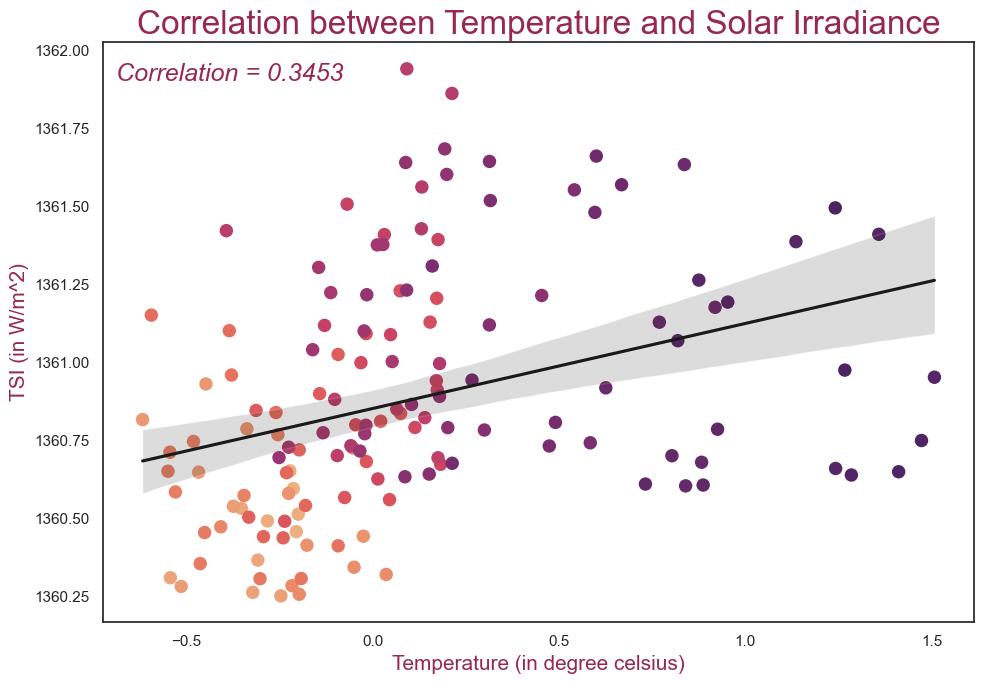

In [32]:
#Find correlation between Temperature and Solar Irradiance
temp_sr_cor = np.corrcoef(TEMP_SIR_df.Temperature, TEMP_SIR_df.TSI)

#Scatter Plot of Temperature vs TSI
sns.set(rc={'figure.figsize':(10,7)})

#Set background colour as white
sns.set_style(style = 'white')

#Add points on the plot
plt.scatter(x = TEMP_SIR_df["Temperature"], y = TEMP_SIR_df["TSI"], c = TEMP_SIR_df["Year"], s = 75, cmap = "flare")

#Add regression line which indicates relationship between the two
sns.regplot(x = "Temperature", y = "TSI", data = TEMP_SIR_df, scatter = False, color = ".1")

#Add correlation as text on the plot
plt.text(-0.69, 1361.9, "Correlation = 0.3453", fontsize = 18, fontstyle = "oblique", ha = "left", color = "#96294c")

#Add labels and title
plt.xlabel("Temperature (in degree celsius)", fontsize = 15, color = "#96294c")
plt.ylabel("TSI (in W/m^2)", fontsize = 15, color = "#96294c")
plt.title("Correlation between Temperature and Solar Irradiance", fontsize = 24, color = "#96294c")

#Use tight layout
plt.tight_layout()

#Display the plot
plt.show()

# Visualization of Temperature vs Solar Irradiance Activity

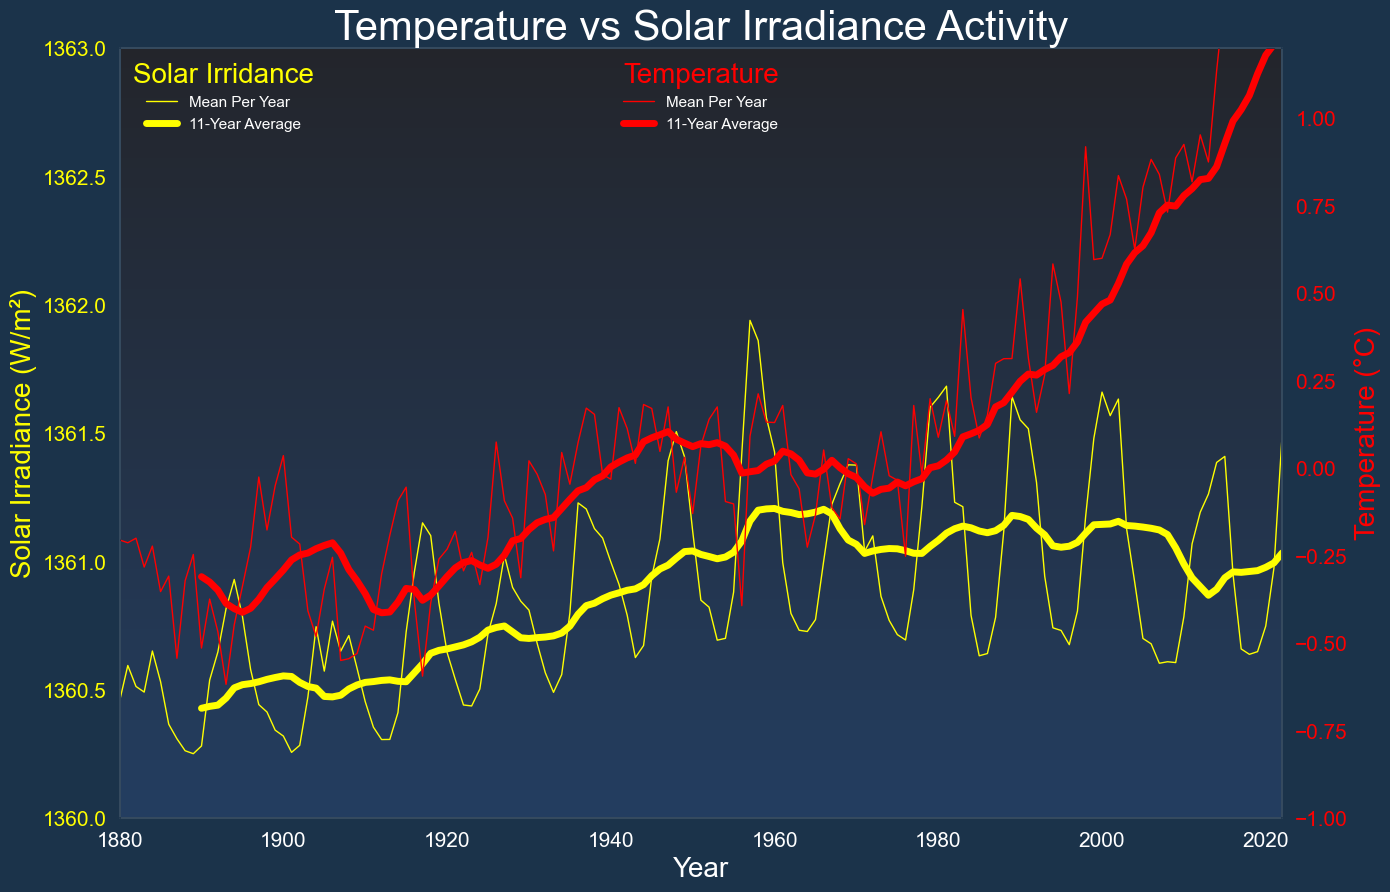

In [33]:
#Calculate 11-year moving average of Temperature and Solar irridance, to display an average line on plot for better visualization
TEMP_SIR_df['TSI_Moving_Avg'] = TEMP_SIR_df['TSI'].rolling(window = 11).mean()
TEMP_SIR_df['Temperature_Moving_Avg'] = TEMP_SIR_df['Temperature'].rolling(window = 11).mean()

#Set figure size, axis background colour for the plot
sns.set(rc={'figure.figsize':(15,10), 'axes.facecolor':'#1b334a', 'figure.facecolor':'#1b334a'})

#Create gradient background
cmap = sns.dark_palette("#27d", as_cmap = True)
gradient = np.linspace(0, 1, 256).reshape(-1, 1)
background = cmap(gradient)
plt.imshow(background, aspect = 'auto', extent = (TEMP_SIR_df['Year'].min(), TEMP_SIR_df['Year'].max(), 1353, 1363))

#Line Plot of solar irradiance on left y-axis
ax1 = sns.lineplot(data = TEMP_SIR_df, x = 'Year', y = 'TSI', color = 'yellow', label = 'Mean Per Year', linewidth = 1)

#Plot 11-year moving average of solar irradiance on left y-axis
sns.lineplot(data = TEMP_SIR_df, x = 'Year', y = 'TSI_Moving_Avg', color = 'yellow', label = '11-Year Average', linewidth = 5)

#Create plot with twin axes. One for solar irradiance and 2nd for global mean temperature
ax2 = ax1.twinx()

#Plot global mean temperature on right y-axis
sns.lineplot(data = TEMP_SIR_df, x = 'Year', y = 'Temperature', color = 'red', label = 'Mean Per Year', linewidth = 1)

#Plot 11-year moving average of temperature on right y-axis
sns.lineplot(data = TEMP_SIR_df, x = 'Year', y = 'Temperature_Moving_Avg', color = 'red', label = '11-Year Average',  linewidth = 5)

#Set limits for left and right y-axis
ax1.set_ylim(1360, 1363)
ax2.set_ylim(-1, 1.2)

#For aesthetics
#Remove y-axis ticks for both the plots
ax1.tick_params(left = False)
ax2.tick_params(right = False)

#Change axis line colour to match with background colour
ax2.spines['top'].set_color('#1b334a')
ax2.spines['bottom'].set_color('#1b334a')
ax2.spines['right'].set_color('#1b334a')
ax2.spines['left'].set_color('#1b334a')

#Set x-axis labels colour to white
ax1.xaxis.label.set_color('white')

#Set y-axis lables colour to yellow and red respectively. Also set fontsize to 15.
ax1.tick_params(axis = 'x', colors = 'white', labelsize = 15)
ax1.tick_params(axis = 'y', colors = 'yellow', labelsize = 15)
ax2.tick_params(axis = 'y', colors = 'red', labelsize = 15)

#For plot 1, change legend position, remove frame, add title and use only 1 column so that all labels are vertically alligned
legend1 = ax1.legend(title = 'Solar Irridance', loc = 'upper left', frameon = False, ncol = 1)
#Set legend title colour and fontsize
plt.setp(legend1.get_title(), color = 'yellow', fontsize = 20)
#Set colour of legend label text to white
for text in legend1.get_texts():
    text.set_color("white")
    
#For plot 2, change legend position, remove frame, add title and use only 1 column so that all labels are vertically alligned
legend2 = ax2.legend(title = 'Temperature', loc = 'upper center', frameon = False, ncol = 1)
#Set legend title colour and fontsize
plt.setp(legend2.get_title(), color = 'red', fontsize = 20)
#Set colour of legend label text to white
for text in legend2.get_texts():
    text.set_color("white")

#Set title and labels
ax1.set_xlabel('Year', size = 20)
ax1.set_ylabel('Solar Irradiance (W/m²)', color = 'yellow', size = 20)
ax2.set_ylabel('Temperature (°C)', color = 'red', size = 20)
plt.title('Temperature vs Solar Irradiance Activity', color = 'white', size = 30)

#Remove grid lines
ax1.grid(False)
ax2.grid(False)

#Save plot as image on local drive
#plt.savefig(r'Media\Temp_Solar_Plot.jpg')

#Display the plot
plt.show()